In [1]:
reset -fs

In [2]:
import numpy as np
import pandas as pd
import os
import glob
import pickle
import gzip
import h5py
import dl_functions
from IPython.display import display
from keras.models import Sequential, model_from_json, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, Input
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.applications.vgg19 import VGG19, preprocess_input
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.
//anaconda/envs/wellio/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
VGG19(weights='imagenet')

In [4]:
vgg19 = VGG19(weights='imagenet')

### Take a look at the VGG19 architecture.

In [5]:
vgg19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### VGG19 expects images of size 224.

In [6]:
IMG_SIZE = 224

### Folder where images are downloaded.

In [7]:
ok_images='/Users/carles/Desktop/data/ok'

In [8]:
nok_images='/Users/carles/Desktop/data/nok'

### Pre-processing images.

In [9]:
X = np.vstack((dl_functions.normalize_images_array(ok_images, IMG_SIZE), dl_functions.normalize_images_array(nok_images, IMG_SIZE)))

### Since we are not using a GPU, we will get a random sample from the OK and NOK images. We know the OK images are the first 10,000, the NOK ones the last 10,000.

In [10]:
X_ok = X[:10000]

In [11]:
X_nok = X[10000:]

In [12]:
ARRAY_SAMPLE = 200

### We get a random sample of the OK and NOK images.

In [13]:
X_ok_sample = X_ok[np.random.randint(0, X_ok.shape[0], ARRAY_SAMPLE)]

In [14]:
X_nok_sample = X_nok[np.random.randint(0, X_nok.shape[0], ARRAY_SAMPLE)]

### Creating final array of images ready to fit a model.

Note that we stack first the 'good' images, then the 'bad' ones.

In [15]:
X = np.vstack((X_ok_sample, X_nok_sample))

### Creating labels.

Label 1 indicates good image, and 0 bad image. Note that half of the images are good, half are bad, so labels are calculated accordingly.

In [16]:
y = np.vstack((np.array([1]*(len(X)/2)).reshape((len(X)/2), 1), np.array([0]*(len(X)/2)).reshape((len(X)/2), 1)))

### Train, test split.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### The labels need to be converted to categorical. Note that we have 2 categories: good (1) and bad (0) images.

In [18]:
y_train_sparse = np_utils.to_categorical(y_train, 2)

In [19]:
y_test_sparse = np_utils.to_categorical(y_test, 2)

### Function to create a pre-trained model.

In [20]:
# https://github.com/fchollet/keras/issues/4465
def pretrained_model(img_shape, num_classes, layer_type):
    # Using VGG19 as base model.
    base_model = VGG19(weights='imagenet')
    # We extract features up to the indicated layer.
    model = Model(input=base_model.input, output=base_model.get_layer('block5_pool').output)
    
    # This is the input format of our images.
    keras_input = Input(shape=img_shape, name='image_input')
    
    # Use the generated model from VGG19.
    output_model = model(keras_input)
    
    # Add fully-connected layers.
    x = Flatten(name='flatten')(output_model)
    x = Dense(4096, activation=layer_type, name='fc1')(x)
    x = Dense(4096, activation=layer_type, name='fc2')(x)
    x = Dense(num_classes, activation='softmax', name='predictions')(x)
    
    # Creating an instance of our model that uses VGG19 extracted features.
    pretrained_model = Model(inputs=keras_input, outputs=x)
    pretrained_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return pretrained_model

In [21]:
model = pretrained_model(X_train.shape[1:], 2, 'relu')

/anaconda/envs/wellio/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("bl..., inputs=Tensor("in...)`


In [22]:
model.fit(X_train, y_train_sparse, batch_size=128, epochs=5, validation_split=0.1, verbose=1)

Train on 252 samples, validate on 28 samples
Epoch 1/5
252/252 [==============================] - 612s - loss: 4.6225 - acc: 0.4484 - val_loss: 8.0151 - val_acc: 0.5000
Epoch 2/5
252/252 [==============================] - 616s - loss: 8.1423 - acc: 0.4921 - val_loss: 8.0151 - val_acc: 0.5000
Epoch 3/5
252/252 [==============================] - 626s - loss: 8.1423 - acc: 0.4921 - val_loss: 8.0151 - val_acc: 0.5000
Epoch 4/5
252/252 [==============================] - 644s - loss: 8.1423 - acc: 0.4921 - val_loss: 8.0151 - val_acc: 0.5000
Epoch 5/5
252/252 [==============================] - 598s - loss: 8.1423 - acc: 0.4921 - val_loss: 8.0151 - val_acc: 0.5000


In [23]:
score = model.evaluate(X_test, y_test_sparse, verbose=True)

120/120 [==============================] - 72s     


In [24]:
print('Test loss: {:0,.4f}'.format(score[0]))
print('Test accuracy: {:.2%}'.format(score[1]))

Test loss: 7.7479
Test accuracy: 51.67%


### Creating a list of predictions.

In [25]:
predicted_images = []
for i in model.predict(X_test):
    predicted_images.append(np.where(np.max(i) == i)[0])

### Displaying a confusion matrix.

dl_functions.py:254: RuntimeWarning: invalid value encountered in divide
  'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),


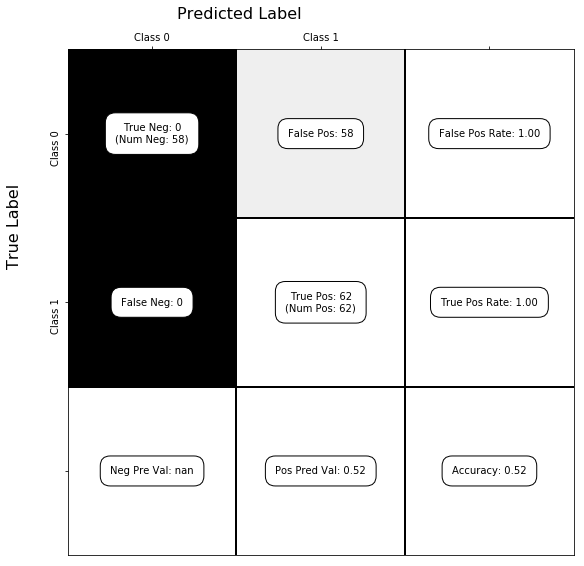

In [26]:
dl_functions.show_confusion_matrix(confusion_matrix(y_test, predicted_images), ['Class 0', 'Class 1'])